#### *LSTM*

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error


from datetime import datetime, timedelta
import yfinance as yf

In [2]:
# Task1 : Preparartion of the dataset

# A function to genrate a a dataframe containing a date column, where the dates for n days are populated until the end date,
# in chronological order:
def generate_date_column(end_date, n):
    # Convert the end date to a pandas Timestamp
    end_date = pd.to_datetime(end_date)
    
    # Generate a date range of N days in the past
    date_column = pd.date_range(end=end_date, periods=n, freq='D')

    # Create a DataFrame with a 'Date' column
    date_df = pd.DataFrame({'Date': date_column})
    
    return date_df

prediction_freq = 5  # Number of times the LSTM model has to make predictions for the next 3 months using the previous 18 months of data
date_df = generate_date_column(end_date='2023-12-08', n=((18 + 3) * 30) * prediction_freq)

#Downloading the stock data from Yahoo Finance for the dates in the date_df
start_date = date_df.at[0, 'Date']

#If you want the data for the last date in the date_df, 
# you must give the date followed by 1 day to get the data of the last date in date_df
end_date = str(date_df.at[len(date_df)-1, 'Date'].date() + timedelta(days = 1)) 

yf_tsla_close = yf.download('TSLA', start = start_date , end = end_date)['Close'].reset_index()

tsla_close_df = pd.merge(date_df, yf_tsla_close, on = 'Date', how = 'left').interpolate(method='linear', limit_direction='both')

# Splitting our tsla_close_df into parts, 
# where each part is used to train the LSTM for 18 months and make predictions for 3months 
split_df_list = np.array_split(tsla_close_df, prediction_freq)


class LSTMPrediction:

    def __init__(self):
        # Create instance of scaler
        self.__scaler = MinMaxScaler(feature_range=(0, 1))
        # Create model object
        self.__model = Sequential()

    def __scaleData(self, close_data):
        scaled_close_data = self.__scaler.fit_transform(close_data)
        return scaled_close_data

    def __prepTrainData(self, scaled_close_data):
        # Preparing data for input to LSTM model
        X_train, y_train = [], []
        for i in range(20, len(scaled_close_data)-(3*30)):
            X_train.append(scaled_close_data[i-20:i, 0])
            y_train.append(scaled_close_data[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        return X_train, y_train
    
    def __buildAndFitModel(self, X_train, y_train):
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Reshape data for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Fit the model
        model.fit(X_train, y_train, epochs=5, batch_size=1)

        # Set the trained model to the instance variable
        self.__model = model


    def __predict(self, scaled_close_data):
        X_pred = []
        for i in range(len(scaled_close_data) - (3*30), len(scaled_close_data)):
            X_pred.append(scaled_close_data[i - 20:i, 0])  # Use sequences of length 20

        X_pred = np.array(X_pred)

        # Ensure that the input shape matches the model's expectations using padding
        if X_pred.shape[1] < self.__model.input_shape[1]:
            pad_width = self.__model.input_shape[1] - X_pred.shape[1]
            X_pred = np.pad(X_pred, ((0, 0), (pad_width, 0)))

        X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

        predictions = self.__model.predict(X_pred)
        predictions = self.__scaler.inverse_transform(predictions)
        return predictions



    def getPredictions(self, close_data):
        scaled_data = self.__scaleData(close_data)
        X_train, y_train = self.__prepTrainData(scaled_data)
        self.__buildAndFitModel(X_train, y_train)
        return self.__predict(scaled_data)

# Training the LSTM and makinbg prediction for each of the datasets:
stock_predictor = LSTMPrediction()

predictions_list = []
for tsla_close_df in split_df_list:
    close_prices_data = tsla_close_df[['Close']].values
    predictions_list.append(stock_predictor.getPredictions(close_prices_data))

predictions_list

[*********************100%%**********************]  1 of 1 completed


Epoch 1/5

520/520 [==============================] - 6s 6ms/step - loss: 0.0113
Epoch 2/5
520/520 [==============================] - 3s 7ms/step - loss: 0.0038
Epoch 3/5
520/520 [==============================] - 3s 6ms/step - loss: 0.0029
Epoch 4/5
520/520 [==============================] - 3s 6ms/step - loss: 0.0018
Epoch 5/5
3/3 [==============================] - 1s 7ms/step
Epoch 1/5
520/520 [==============================] - 5s 6ms/step - loss: 0.0113
Epoch 2/5
520/520 [==============================] - 3s 6ms/step - loss: 0.0051
Epoch 3/5
520/520 [==============================] - 3s 6ms/step - loss: 0.0035
Epoch 4/5
520/520 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 5/5
3/3 [==============================] - 0s 6ms/step
Epoch 1/5
520/520 [==============================] - 6s 7ms/step - loss: 0.0046
Epoch 2/5
520/520 [==============================] - 4s 7ms/step - loss: 0.0025
Epoch 

[array([[13.058301 ],
        [13.009333 ],
        [12.972328 ],
        [13.242194 ],
        [13.582938 ],
        [13.417978 ],
        [13.363128 ],
        [13.402836 ],
        [13.47387  ],
        [13.544283 ],
        [13.536363 ],
        [13.518433 ],
        [13.608193 ],
        [13.420424 ],
        [13.3112335],
        [13.259584 ],
        [13.222777 ],
        [12.859816 ],
        [12.60177  ],
        [12.526347 ],
        [12.700219 ],
        [12.830329 ],
        [12.901277 ],
        [12.947396 ],
        [13.035916 ],
        [12.805988 ],
        [12.474043 ],
        [12.539731 ],
        [12.502015 ],
        [12.374318 ],
        [12.216513 ],
        [12.284362 ],
        [12.346126 ],
        [12.599059 ],
        [12.509755 ],
        [12.427148 ],
        [12.391362 ],
        [12.381283 ],
        [12.716233 ],
        [12.954772 ],
        [13.087898 ],
        [13.18463  ],
        [13.182009 ],
        [13.153558 ],
        [13.1331005],
        [1

In [3]:
predictions_list

[array([[13.058301 ],
        [13.009333 ],
        [12.972328 ],
        [13.242194 ],
        [13.582938 ],
        [13.417978 ],
        [13.363128 ],
        [13.402836 ],
        [13.47387  ],
        [13.544283 ],
        [13.536363 ],
        [13.518433 ],
        [13.608193 ],
        [13.420424 ],
        [13.3112335],
        [13.259584 ],
        [13.222777 ],
        [12.859816 ],
        [12.60177  ],
        [12.526347 ],
        [12.700219 ],
        [12.830329 ],
        [12.901277 ],
        [12.947396 ],
        [13.035916 ],
        [12.805988 ],
        [12.474043 ],
        [12.539731 ],
        [12.502015 ],
        [12.374318 ],
        [12.216513 ],
        [12.284362 ],
        [12.346126 ],
        [12.599059 ],
        [12.509755 ],
        [12.427148 ],
        [12.391362 ],
        [12.381283 ],
        [12.716233 ],
        [12.954772 ],
        [13.087898 ],
        [13.18463  ],
        [13.182009 ],
        [13.153558 ],
        [13.1331005],
        [1

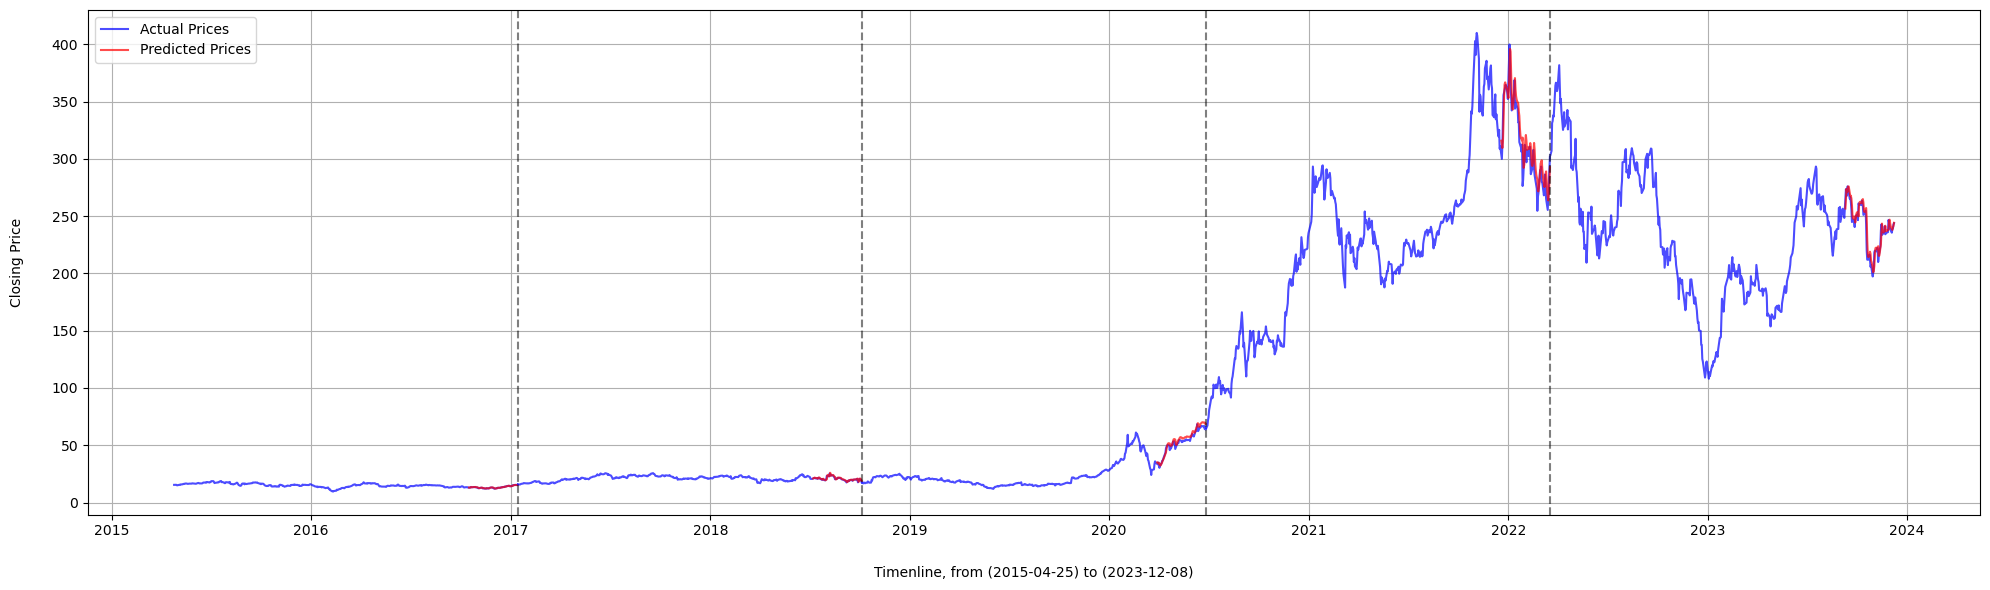

In [4]:
import matplotlib.pyplot as plt

# Create a single figure
fig, ax = plt.subplots(figsize=(20, 6))

# Plot on main axes
actual_prices_lines = []
predicted_prices_lines = []

for df, predictions in zip(split_df_list, predictions_list):
    actual_prices_lines.append(ax.plot(df['Date'], df['Close'], color='blue', alpha=0.7))
    predicted_prices_lines.append(ax.plot(df['Date'][-len(predictions):], predictions, color='red', alpha=0.7))

# Flatten all lines into single lists for legend creation
all_actual_prices_lines = [line for sublist in actual_prices_lines for line in sublist]
all_predicted_prices_lines = [line for sublist in predicted_prices_lines for line in sublist]

# Add dashed vertical lines to separate plots
for i, df in enumerate(split_df_list):
    if i < len(split_df_list) - 1:
        ax.axvline(x=df['Date'].iloc[-1], color='black', linestyle='--', alpha=0.5)

# Set common labels and legend
ax.set_xlabel('Timenline, from (2015-04-25) to (2023-12-08)', labelpad=20)
ax.set_ylabel('Closing Price', labelpad=20)
ax.legend(handles=[all_actual_prices_lines[0], all_predicted_prices_lines[0]], labels=['Actual Prices', 'Predicted Prices'], loc='upper left')

# Add grid lines for better visual comparison
ax.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

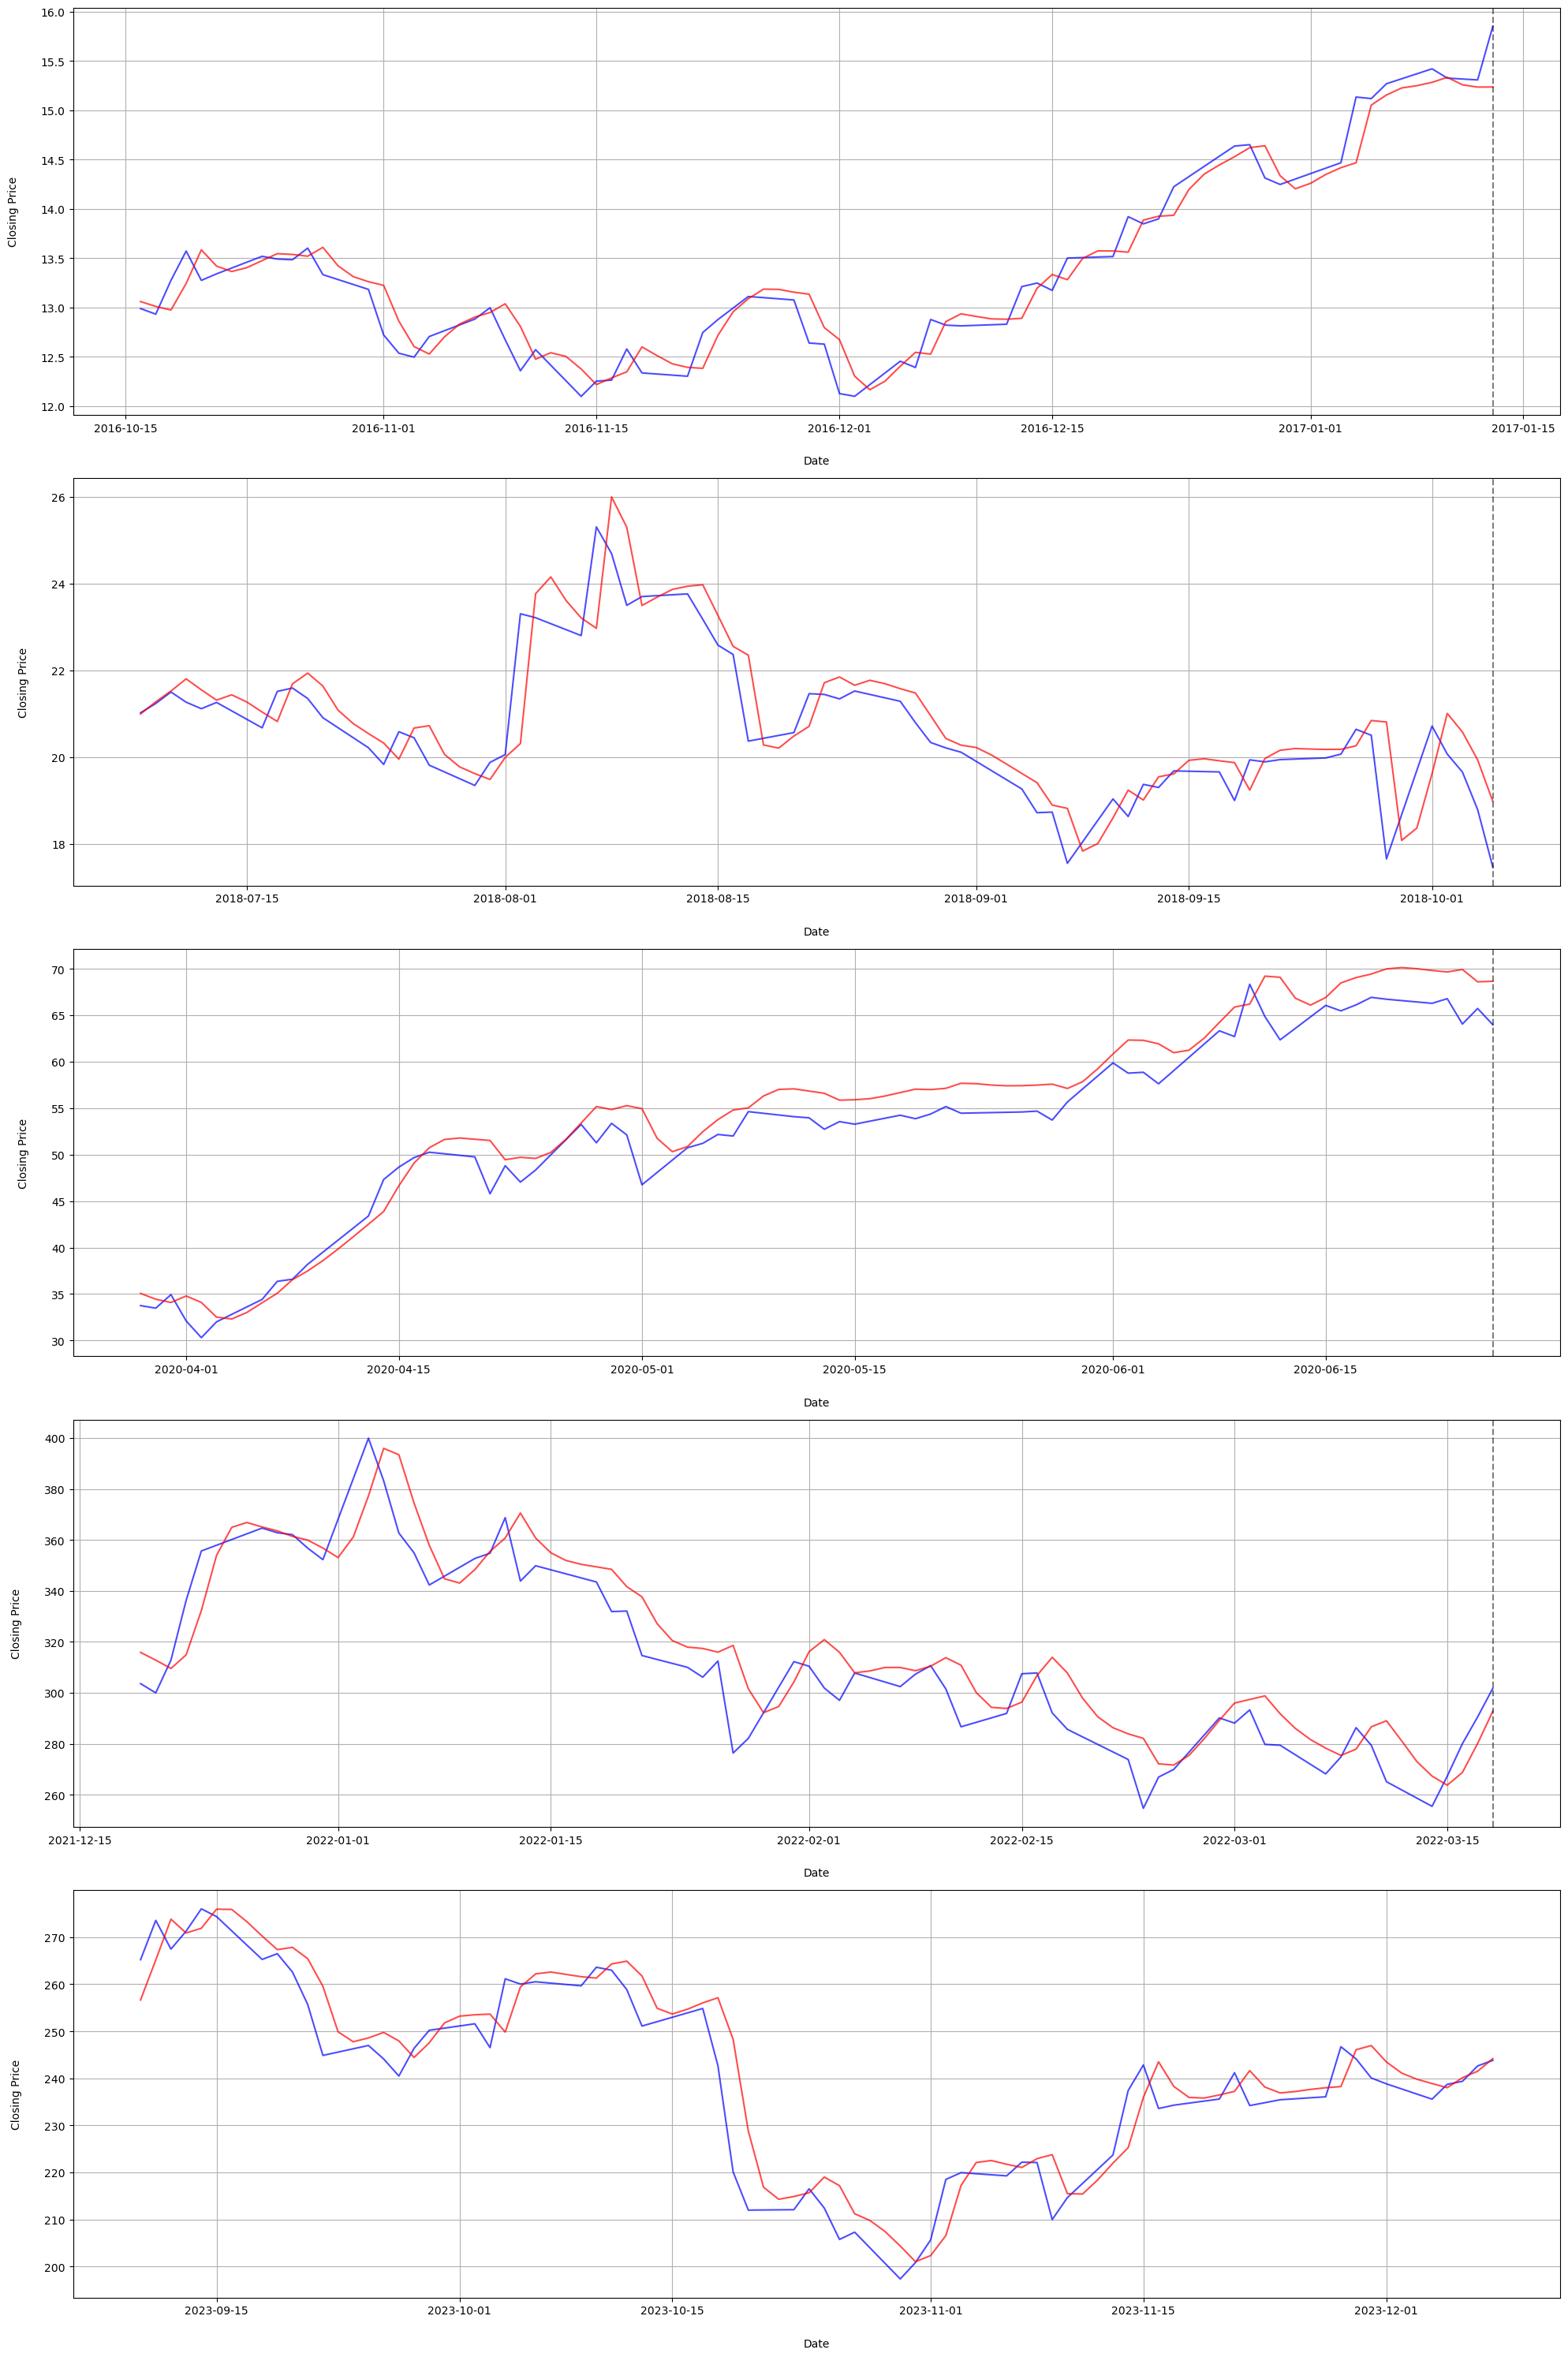

In [5]:
import matplotlib.pyplot as plt

# Define number of rows and columns for subplots
nrows = len(split_df_list)
ncols = 1

# Create a figure with the desired dimensions
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 6 * nrows))

# Plot actual and predicted prices on individual axes
for i, (df, predictions) in enumerate(zip(split_df_list, predictions_list)):
    # Access the corresponding axis for each split dataset
    ax = axes[i]

    # Plot actual and predicted prices
    ax.plot(df['Date'].tail(3 * 30), df['Close'].tail(3 * 30), color='blue', alpha=0.7, label='Actual Prices')
    ax.plot(df['Date'][-len(predictions):], predictions, color='red', alpha=0.7, label='Predicted Prices')

    # Add dashed vertical lines to separate plots within each subplot
    if i < nrows - 1:
        ax.axvline(x=df['Date'].iloc[-1], color='black', linestyle='--', alpha=0.5)

    # Set individual axis labels
    ax.set_xlabel('Date', labelpad=20)
    ax.set_ylabel('Closing Price', labelpad=20)

    # Add grid lines for better visual comparison
    ax.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


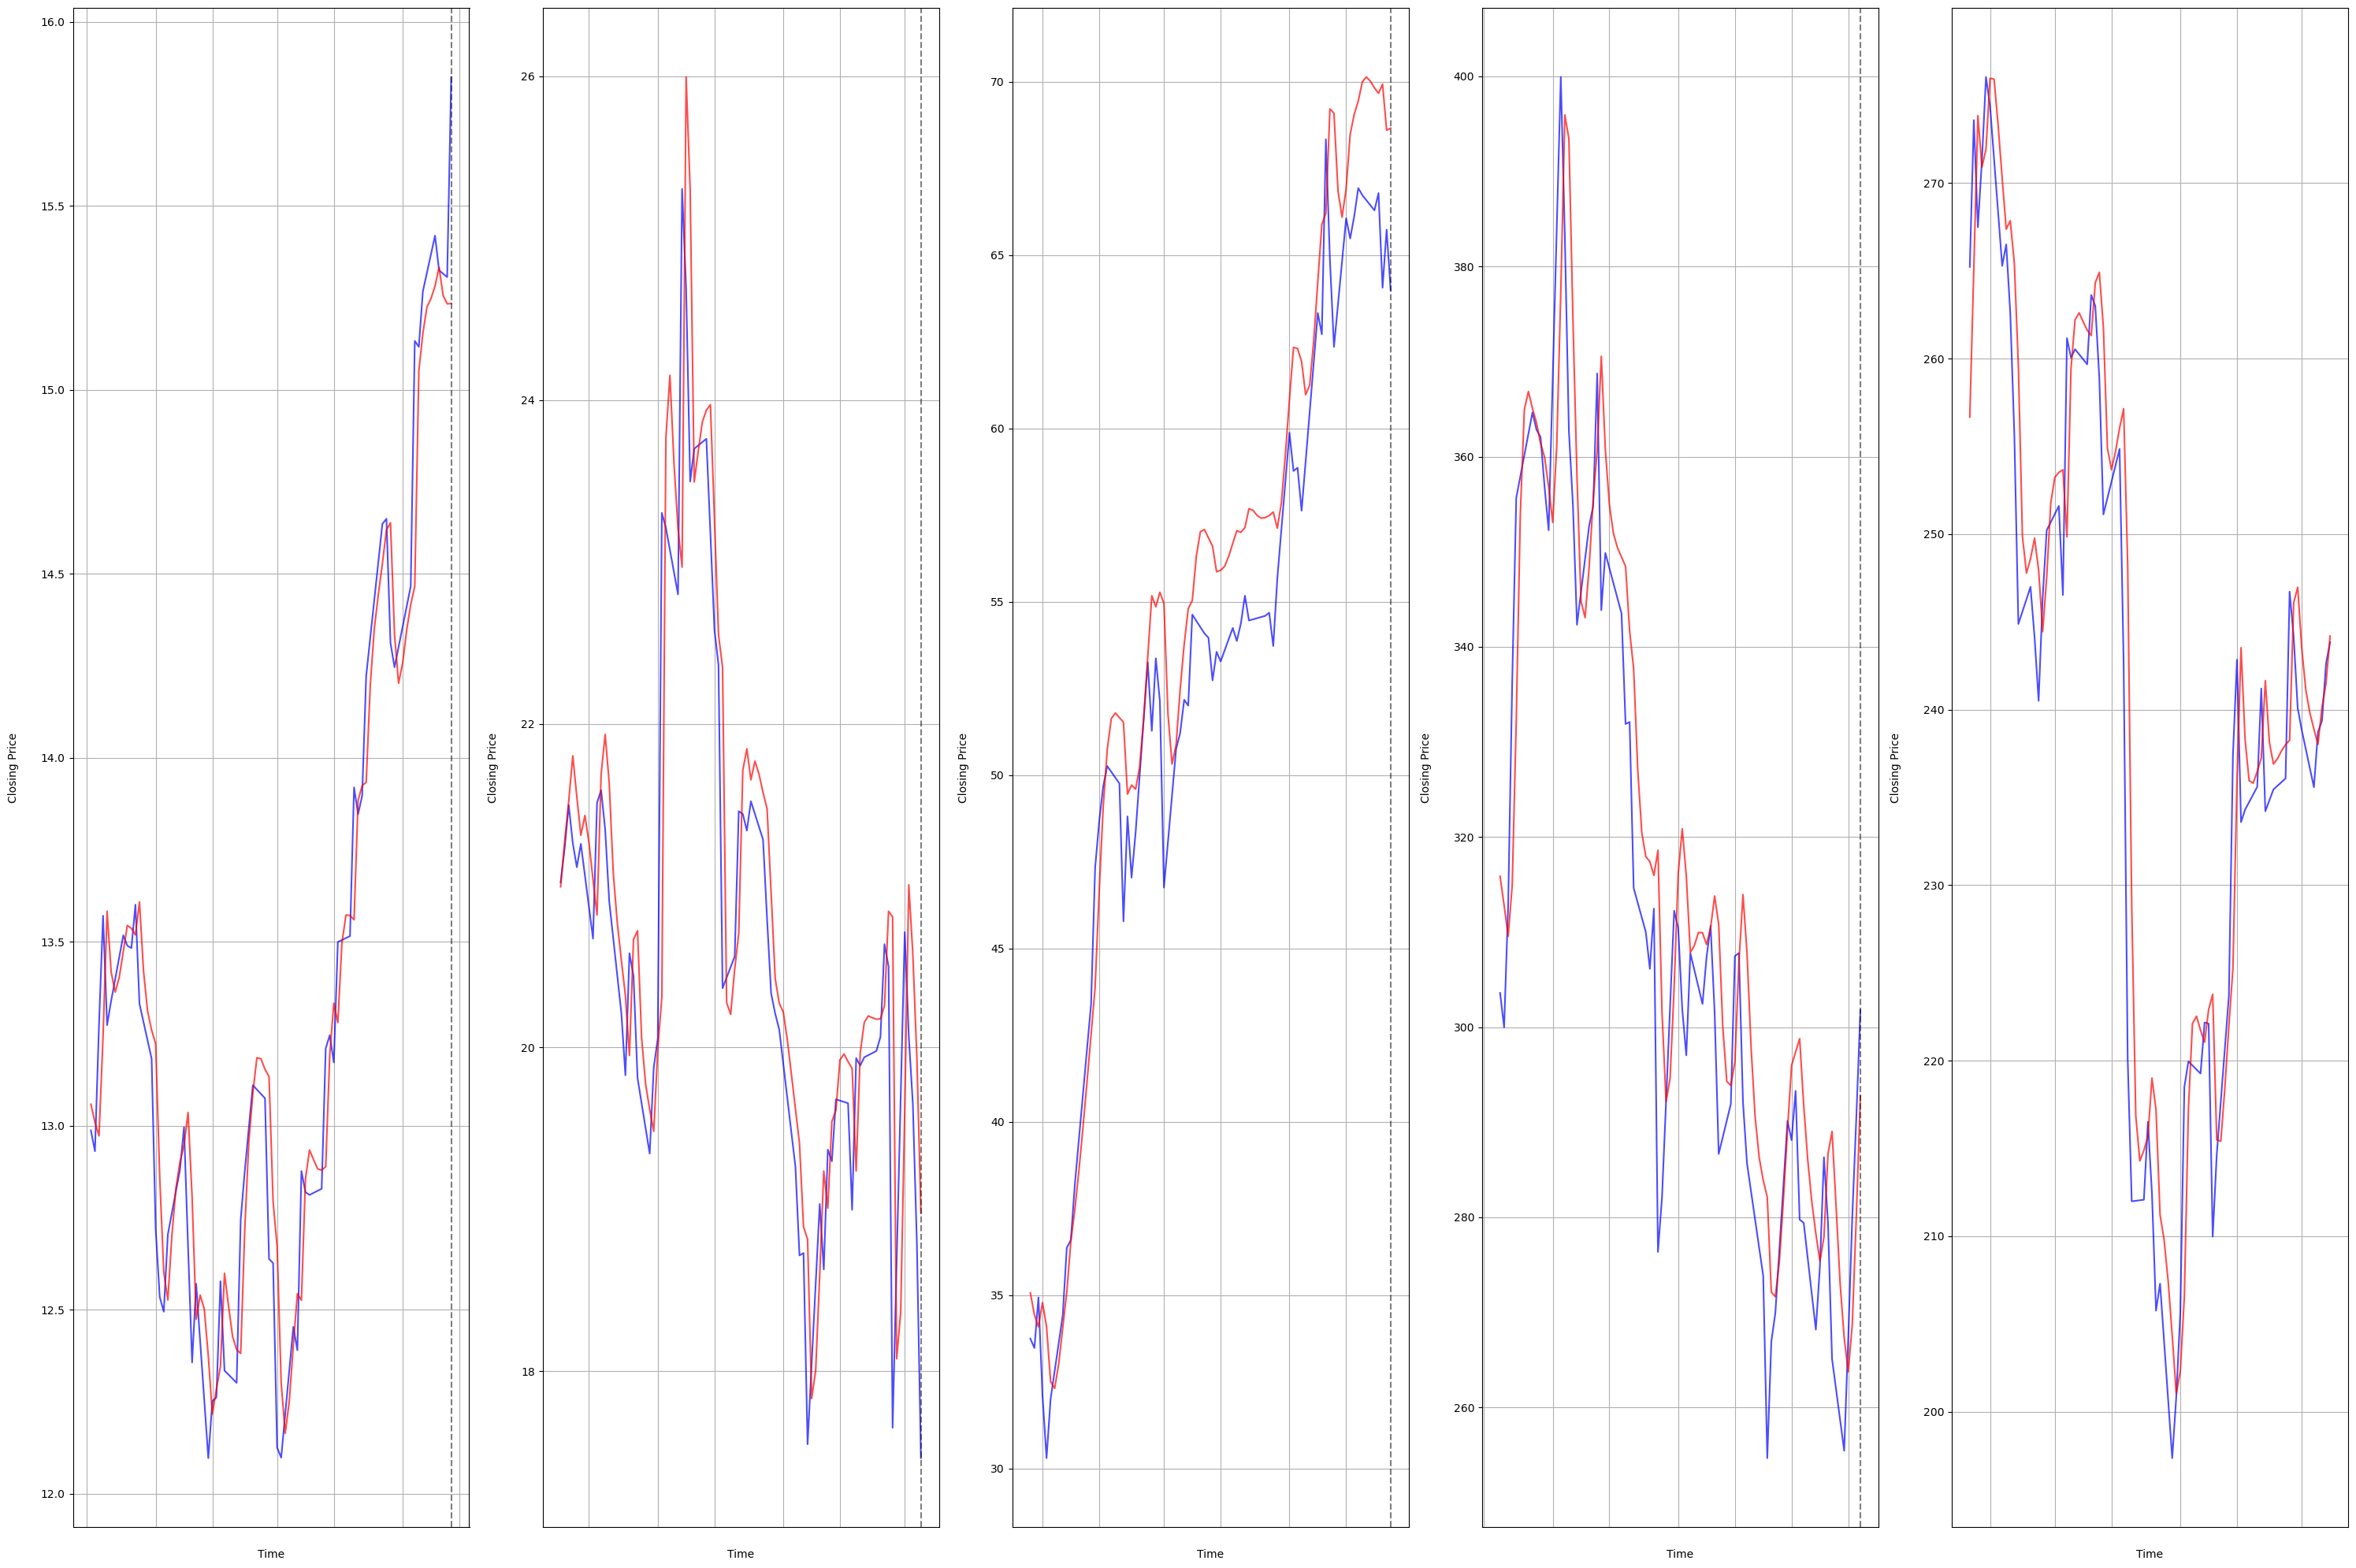

In [6]:
import matplotlib.pyplot as plt

# Define number of rows and columns for subplots
nrows = 1
ncols = len(split_df_list)

# Create a figure with the desired dimensions
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 20))

# Plot actual and predicted prices on individual axes
for i, (df, predictions) in enumerate(zip(split_df_list, predictions_list)):
    # Access the corresponding axis for each split dataset
    ax = axes[i]

    # Plot actual and predicted prices
    ax.plot(df['Date'].tail(3 * 30), df['Close'].tail(3 * 30), color='blue', alpha=0.7, label='Actual Prices')
    ax.plot(df['Date'][-len(predictions):], predictions, color='red', alpha=0.7, label='Predicted Prices')

    # Add dashed vertical lines to separate plots within each subplot
    if i < ncols - 1:
        ax.axvline(x=df['Date'].iloc[-1], color='black', linestyle='--', alpha=0.5)

    # Set individual axis labels
    ax.set_xlabel('Time',labelpad=20)
    ax.set_ylabel('Closing Price',labelpad=20)

    # Add grid lines for better visual comparison
    ax.grid(True)

# Disable x-ticks for all subplots
for ax in axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [8]:
rmse_lstm = 0
for i in range(0, prediction_freq):
    # Flatten predictions
    predictions_flat = predictions_list[i].flatten()

    # Convert actual values to Unix timestamps
    actual_values = split_df_list[i][-len(predictions_flat):]['Close']

    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions_flat)

    # Calculate and accumulate RMSE
    rmse_lstm += (1/prediction_freq) * np.sqrt(mse)

# Print the RMSE values
print(f"RMSE for LSTM averaged for predictions over all {prediction_freq} periods: {rmse_lstm}")


RMSE for LSTM averaged for predictions over all 5 periods: 4.6984663149881385
